# 🧠 Multi-Agent Wellbeing Assistant

This autonomous research assistant was designed to produce a **Personalised Wellbeing Action Plan** in response to a problem reported by a user.  
At its core, this LLM-based agentic system curates knowledge from web and Wikipedia resources to generate a set of highly **customised steps** that users can take to improve their wellbeing. The resulting wellbeing action plan is output as a comprehensive report.

> **Note:** The system’s output should be viewed as a personalised wellbeing blog, **not medical advice**. It is intended for **guidance only**.

-----

## Tools

- Multi-agent architecture and workflow orchestration with **LangChain / LangGraph**
- **Chat models used:** 
    - GPT-5 mini -> for final deliverable
    - GPT-4o -> reasoning-heavy tasks and structured outputs adhering to a set schema 
    - GPT-4.1 mini -> summarisation


- **Pydantic-based schemas** for model adherence
- **Tavily API** integration for web search
- **WikipediaLoader** from the LangChain community

-----

## Core design concepts

- Planning module utilising two LLM experts: planner and feedback generator (draft → refine).
- **Human-in-the-Loop** for unlimited user feedback over the general shape of the plan.
- **ReAct** and **Chain-of-Thought** frameworks employed throughout the system.
- LLM-powered knowledge curation inspired with Stanford's **STORM**.  
- Parellel execution for time efficiency.
- Map-reduce branching pattern for dynamic and efficient processing.
- Context engineering via summarisation.

-----

## Detailed design

### **1. User Input**

A user describes the problem they are facing and specifies the number of steps they would like their wellbeing action plan to include.  

**Example input:**  
> “I’m feeling very stressed at work because I don’t like being surrounded by many people in an open office.”


### **2. Planning Stage**

After receiving the user’s problem, the system generates the specified number of steps, each containing a domain (theme) and a helpful tip.

**Example output:**

`- Step -`

***`Theme:`*** `Workplace adjustments`  

***`Helpful tip:`*** `Consider discussing with your manager the possibility of creating a more private workspace, such as using partitions or screens, to help reduce the feeling of being surrounded by many people. Additionally, explore flexible work hours to avoid peak office times, which may further alleviate stress.`

- The plan is generated within a **subgraph** that maintains its own state, employing the **ReAct** and **Chain-of-Thought** frameworks.  
- A **human-in-the-loop** process allows users to review and suggest changes before deeper research begins.  


### **3. Consultation Stage**

This **LLM-powered knowledge curation** process is inspired by Stanford’s [STORM](https://github.com/stanford-oval/storm).

- **Simulated Conversation:** One agent acts as a *client* attending a wellbeing consultation, while another plays the role of a *practitioner* whose knowledge is grounded in web and Wikipedia sources.  
- **Perspective-Guided Question Asking:** The client’s questions are guided by their (user) problem, initial wellbeing plan and the practitioner’s evolving responses.  
- This multi-turn dialogue serves as a mechanism for identifying and retrieving relevant source documents (web/Wiki).  
- Consultations are executed **in parallel** across multiple sub-graphs using a **map-reduce** pattern.  


### **4. Final Plan Generation**

- Source documents and consultation transcripts are synthesized into a **final wellbeing action plan**.  
- References to the consulted sources are included.  
- The **format of the final plan** is customisable.  

---



In [1]:
# Get src root and add to sys paths (necessary for logging utilities)
import sys
from pathlib import Path

project_root = Path.cwd().parent
src_path = project_root / "src"

sys.path.append(str(src_path))

# Tools
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import interrupt, Send, Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.messages import get_buffer_string, RemoveMessage
from IPython.display import Image, display, Markdown
from typing_extensions import TypedDict
from typing import List, Annotated, Sequence
import operator
from pydantic import BaseModel, Field
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader

# Custom tools for logging (optional)
from utils.logging_utils import log, init_timer

`OpenAI API key` and `Tavily API key` will be required to run the assistant. Please make sure to provide them in the `.env` file following a template from `.env.example` If you prefer to use a different chat model provider, you can find available options [here](https://docs.langchain.com/oss/python/integrations/providers/overview).

In [2]:
# Load environment variables (API keys)
env_path = project_root / ".env"
load_dotenv(dotenv_path=env_path, override=True)

os.environ["LANGSMITH_PROJECT"] = "wellbeing_assistant" # optional integration with LangSmith for tracking

In [3]:
# Instatiate chat models. Please note the project utilises three different OpenAI models for different tasks (as described in the introduction).
llm_4o = ChatOpenAI(model="gpt-4o-2024-11-20", temperature=0) 
llm_4_1_mini = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0)
llm_5_mini = ChatOpenAI(model="gpt-5-mini-2025-08-07", temperature=0)

In [4]:
# Schema for the Advice Planning subgraph
class Step(BaseModel):
    theme: str = Field(
        description="A theme which could be explored to improve the person's wellbeing in the context of the problem that they presented."
        )
    helpful_tip: str = Field(
        description="A piece of advice which follows the theme."
    )

    @property
    def step_summary(self) -> str:
        return f"Theme: {self.theme}\n\nHelpful tip: {self.helpful_tip}"

class Steps(BaseModel):#
    steps : List[Step] = Field(
        description="A list of steps which could be taken to improve user's wellbeing"
    )

# Advice Planning subgraph state
class AdvicePlanningState(MessagesState):
    problem: str # problem reported by a user
    max_steps: int # maximum number of steps in the wellbing action plan
    max_cycles : int # maximum number of allowed |ai_feedback| -> |advice_planner| cycles
    plan: str # a wellbeing action plan that has been approved by the user
    steps: List[Step] # a list of selected steps in the wellbeing action plan
    cycles_counter : int # for tracking the cycles
    user_feedback : bool # if user provided a feedback to work on

class PlanningOutputState(TypedDict):
    problem: str # problem reported by a user
    steps: List[Step] # a list of selected steps in the wellbeing action plan
    max_cycles : int # maximum number of allowed |ai_feedback| -> |advice_planner| cycles

### Advice planning subgraph

In [5]:
advice_planner_instructions = """# Identity and objectives: 

You are a wellbeing advisor tasked with planning a wellbeing action plan for a user. In doing so, you will be receiving a critical feedback from an another expert and the user. 

Below you will find your conversation with the expert and the user.

# Follow these instructions carefully:

1. First, review the problem reported by the user:

{problem}

2. Review the current state of the conversation.
3. Examine any optional feedback that has been provided by the expert in the conversation.      
4. Examine any optional feedback that has been provided by the user in the conversation. 
5. Preserve as unchanged those themes from the plan for which the expert and the user did not provide a critical feedback (didn't ask to delete or change).
6. Plan up to {max_steps} steps (including the preserved ones) that could be taken to improve the user's wellbeing. 
7. Each step should have its theme. Examples of themes (domains) for those steps include: 
- home remedies,
- conventional medicine,
- lifestyle changes,
- exercises,
- therapy,
- workplace adjustments, 
- other themes (domains) that fit the problem reported by the user.
8. In addition to the theme, each step should be accompanied with one helpful tip (one or two sentences). 
8. You can provide up to three different tips for the same theme, but make sure to assign them to a separate instance of the theme.
9. Here is an example of the expected wellbeing action plan:

"Proposed steps:

- Step -
Theme: Lifestyle changes 
Helpful tip: Improving sleep quality can be effectively achieved by minimising exposure to blue light emitted by electronic devices, particularly in the hours leading up to bedtime.

- Step -
Theme: ...
Helpful tip: ..."

10. Always try to improve the plan based on the feedback from both the user and the expert. If you think the plan cannot be improved any further, output the best version.
11. Don't assume the role of the feedback provider. You are working on the feedback provided.
"""

def advice_planner(state: AdvicePlanningState):
    
    """Advice-planning node"""
    
    cycles_counter = state.get("cycles_counter", -1)
    user_feedback = state.get("user_feedback", False)
    
    # Reset the cycles counter if user feedback was provided and re-work the plan
    if user_feedback: 
        cycles_counter = -1 
        user_feedback = False # reset to False

    # Print a progress message
    if cycles_counter == -1:
        log("[Planner] Drafting the plan...")

    problem = state["problem"]
    conversation = state.get("messages", [])
    max_steps = state.get("max_steps", 3)
    
    # Format the system message
    sys_message =  advice_planner_instructions.format(
        problem=problem,
        max_steps=max_steps
    )

    # Messages list
    messages = [
        SystemMessage(content=sys_message),
        AIMessage(content=f"Plan the wellbeing action plan for the user")
    ]
    
    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    plan = llm_4o.invoke(messages + conversation)

    # Increment the counter
    cycles_counter += 1

    return {
        "messages": [plan], 
        "plan": plan.content,
        "cycles_counter": cycles_counter,
        "user_feedback": user_feedback
        }


In [6]:
feedback_instructions = """# Identity and objectives: 
You assuming a role of an expert at providing feedback for wellbeing action plans. You're known for your scrutiny and critical mindset; however, your feedback is always accurate and fair.

# Follow these instructions carefully:
1. First, review the problem reported by the user:

{problem}

2. Review your previous feedback (so you don't repeat yourself).
3. Review the current version of the wellbeing action plan (the last message in the messages history).        
4. Bear in mind that each step in the plan is intentionally kept short. All steps have their theme and are accompanied with a single helpful tip. 
5. When evaluating the current version of the wellbeing action plan, consider these points:
- Is the plan relevant to the the user's problem? Could anything be changed to increase the relevancy?
- Considering the user's situation, are those helpful tips really helpful? Would adding alternatives help?
- Are the themes in the plan diverse enough so that they approach the user's problem from different angles?
- All helpful tips should be realistic and pragmatic. Perhaps the plan doesn't explore free alternatives?
- Your feedback should be critical but constructive and actionable. 
- Only focus on steps that could be improved and skip commenting on those that are ok.

Example of your feedback:

"Providing feedback for the following steps in the wellbeing action plan:

- Step - 
Theme: Exercises
Helpful tip: Regular running can help reduce stress and improve overall mental wellbeing.

My feedback: The explored theme is relevant as exercises can lower stress levels; however, running can not be apropriate for individuals with mobility issues. I suggest a gentler alternative, such as yoga or pilates.

- Step - 
Theme: ...
Helpful tip: ..."

4. Only output feedback for those steps that could use some additional work. 
5. NEVER output revised version of the plan. Your feedback should limit to the specific steps and should be output in the "My feedback:" section (as seen in the example).
6. Make sure not to repeat your previous feedback.  
7. The plan shouldn't suggest it is a medical advice.
8. CRUCIAL: If you think that no changes are required for the ENTIRE plan, and you approve it, output "No changes required for the plan." 

"""

def feedback_generator(state: AdvicePlanningState):
    
    """Node providing feedback for the advice_planner."""

    problem = state['problem']
    conversation = state['messages']
    
    # Format the system message
    sys_message =  feedback_instructions.format(problem=problem)

    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    feedback = llm_4o.invoke([SystemMessage(content=sys_message)] + conversation)
    feedback.name = "planner"

    return {'messages': [feedback]}


def continue_planning(state: AdvicePlanningState):
    
    """Route based on the feedback from the feedback_generator node and completed |feedback| -> |planning| cycles"""

    cycles_counter = state['cycles_counter']
    max_cycles = state.get('max_cycles', 2) # defaults to 2 full |feedback| -> |planning| cycle
    conversation = state["messages"]

    # Route to the human feedback step if max cycles were reached
    if cycles_counter >= max_cycles:
    
        # Print progress log
        log("[Planner] Max cycles reached.")    
    
        return "human_feedback"
    
    # Route to the human feedback step if AI feedback generator approved the plan
    elif len(conversation) > 1 and conversation[-2].name == "planner" and "No changes required for the plan." in conversation[-2].content:
        
        # Print progress log
        log("[Planner] Draft successfully generated!")
        
        return "human_feedback"
    # Otherwise, continue with AI feedback generation 
    else:
        return "feedback_generator"
    
    
def human_feedback(state: AdvicePlanningState):
    
    """Human feedback node"""

    plan = state["plan"]

    # Interrupt the graph execution, surface current version of the plan and return human input
    user_feedback = interrupt(f"\n\n* * * * *\n\nDo you have any suggestions for the proposed steps in your Wellbeing Action Plan? Type 'No feedback' if none.\n\n{plan}\n\n* * * * *\n\n")

    # Print progress message
    log(f'[User input] Feedback from the user: "{user_feedback}"')
    
    if user_feedback =="No feedback":
        return {"user_feedback" : False}
    else:
        feedback_formatted = f"My (user) feedback:\n\n{user_feedback}"
        return {
            "user_feedback": True, 
            "messages": [HumanMessage(content=feedback_formatted, name="user")]
            }
    
    
def act_on_feedback(state : AdvicePlanningState):
    
    """Route based on human feedback"""    

    user_feedback = state["user_feedback"]

    # If further work is required
    if user_feedback:
        return "advice_planner"
    else:
        return "plan_formatting"


formatting_instructions = """# Identity and objectives: 

You are an assistant tasked with formatting the wellbeing action plan into a set of steps. Each step should have its theme and helpful tip.

# Follow these instructions carefully:

1. Ignore the preamble and summary (if present)
2. Ignore numbers (if present)
3. Don't change the themes and helpful tips. 
4. Your task is to output individual steps according to given schema while preserving the content of the steps.
"""

def plan_formatting(state: AdvicePlanningState):
    
    """Node formatting the drafted plan steps based on expected output schema"""
    
    plan = state['plan']
    
    structured_llm = llm_4o.with_structured_output(Steps)
    structured_plan = structured_llm.invoke([formatting_instructions] + [AIMessage(content=plan)])

    return {"steps": structured_plan.steps}

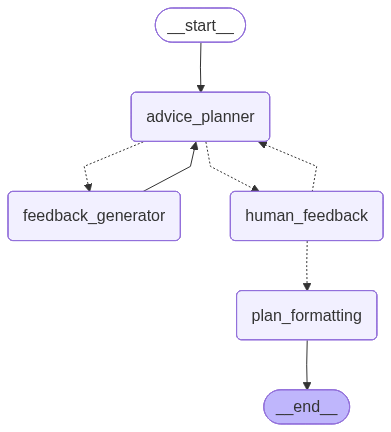

In [7]:
# Add nodes
builder = StateGraph(state_schema=AdvicePlanningState, output_schema=PlanningOutputState)
builder.add_node("advice_planner", advice_planner)
builder.add_node("feedback_generator", feedback_generator)
builder.add_node("human_feedback", human_feedback)
builder.add_node("plan_formatting", plan_formatting)

# Add edges (logic)
builder.add_edge(START, "advice_planner")
builder.add_conditional_edges("advice_planner", continue_planning, ["feedback_generator", "human_feedback"])
builder.add_edge("feedback_generator", "advice_planner")
builder.add_conditional_edges("human_feedback", act_on_feedback, ["plan_formatting", "advice_planner"])
builder.add_edge("plan_formatting", END)

# compile
advice_planning_subgraph = builder.compile()

# Display the subgraph diagram (optional)
display(Image(advice_planning_subgraph.get_graph(xray=1).draw_mermaid_png()))


### Consultation subgraph (research process)

In [8]:
# Consultation subgraph state
class ConsultationState(MessagesState):
    problem: str # user-reported issue
    max_cycles: int # Max number of |question| -> |answer| cycles
    step: Step # an individual step from the plan received through Send() API
    webquery: str # a query constructed for the web search
    wikiquery: str # a query constructed for the Wikipedia search
    transcript: str # transcript from the consultation
    summary: str # summary of the consultation (for exceptionally long lists of messages)
    cycles_counter : int # |question| -> |answer| cycles counter 
    source_docs: Annotated[list, operator.add] # docs with the context the practitioner is using to provide answers
    sections: list # Written section aggregated in the OverallState through Send() API

class ConsultationOutputState(TypedDict):
    sections: list # Written section aggregated in the OverallState through Send() API  

# Schema for the search query formatting
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


question_instructions = """# Identity and objectives:
You are a client who is having an appointment with a wellbeing practitioner. Your objective is to receive in-depth advice tailored to your problem:

{problem}

You finished your previous appointment with the following helpful advice form the practitioner:

{advice}

# Follow these steps:
1. Review your problem.
2. Review the piece of advice you have previously received.
2. Review your current conversation with the practitioner.
3. Review the (optional) summary of the conversation with the practitioner:

{summary}

3. Create a persona that fits the problem you came to discuss and stay in your character throughout the consultation.
3. Begin by greeting the practitioner and ask a follow up question regarding the piece of advice you have received during the last appointment.
4. Continue asking questions until you think the practitioner has offered enough help and clarification on the piece of advice.
5. Be curious, critical about practicalities of the advice you received and ask in-depth questions. Ask for real-world implementations.
6. IMPORTANT: When you feel you don't need more information and all your questions have been answered, finish the consultation by stating: "Thank you and goodbye!"   
"""

def question_generator(state: ConsultationState):
    
    """Node to genarate a question for a single step in the wellbeing action plan."""

    problem = state["problem"]
    step = state["step"]
    conversation = state.get("messages", [])
    summary = state.get("summary", "")

    formatted_question_instructions = question_instructions.format(
        problem = problem,
        advice = step.step_summary,
        summary=summary
    )

    messages = [
        SystemMessage(content=formatted_question_instructions),
        AIMessage(content="Hello! What brings you here today?", name="practitioner") # Prompt the simulated conversation
    ]

    question = llm_4o.invoke(messages + conversation)
    question.name = "client"

    return {"messages": [question]}


def skip_the_search(state: ConsultationState) -> Sequence[str]:
    
    """Logic to determine if the simulated consultation was concluded so that the web/wiki search can be skipped."""

    latest_message = state["messages"][-1]

    if "Thank you and goodbye!" in latest_message.content:
        # Jump to answer_generation node
        return "answer_generator"
    else:
        # Continue with the parallel web and wiki search
        return ["web_query_constructor", "wiki_query_constructor"]


web_query_instructions = """# Identity and objectives:
You are an assistant specialised in creating quality and well-structured search queries for use in web-search. 
You will be given a conversation between a client and a wellbeing practitioner and your goal is to create a query based on that conversation. 

# Follow these steps:
1. Analyse the problem the client came to discuss with the practitioner:

{problem}

2. Analyse the conversation.
3. Analyse (optional) summary of the previous parts of the conversation:

{summary}

4. IMPORTANT: Pay particular attention to the final question posed by the client.
5. Convert this final question into a well-structured web search query"""

def web_query_constructor(state: ConsultationState):
    
    """Node to construct a web search query according to the expected output schema."""

    problem = state["problem"]
    conversation = state["messages"]
    summary = state.get("summary", "")

    formatted_query_instructions = web_query_instructions.format(
        problem=problem,
        summary=summary
    )

    # Force output format
    structured_llm = llm_4o.with_structured_output(SearchQuery)
    # Generate the query
    query = structured_llm.invoke([formatted_query_instructions] + conversation)

    return {"webquery": query.search_query}


wiki_query_instructions = """# Identity and objectives:
You are an assistant specialised in creating quality and well-structured search queries for use in Wikipedia search. 
You will be given a conversation between a client and a wellbeing practitioner and your goal is to create a query based on that conversation. 

# Follow these steps:
1. Analyse the problem the client came to discuss with the practitioner:

{problem}

2. Analyse the conversation.
3. Analyse (optional) summary of the previous parts of the conversation:

{summary}

4. IMPORTANT: Pay particular attention to the final question posed by the client.
5. Convert this final question into a well-structured Wikipedia search query
6. When constructing the query, use these pointers:
* Use specific, unique terms - Search "Fermi paradox" instead of "aliens exist"
* Include proper names when known - Search "Marie Curie radium" instead of "female scientist radioactivity"
* Add disambiguating context for common terms - Search "Python programming" instead of just "Python"
* Use the most common name or spelling - Search "World War II" instead of "Second World War" or "WW2"
* Combine key concepts with AND - Search "Einstein AND photoelectric" instead of "Einstein's work on light"
* Keep the queries short.
"""
def wiki_query_constructor(state: ConsultationState):
    
    """Node to construct a Wikipedia search query according to the expected output schema."""

    problem = state["problem"]
    conversation = state["messages"]
    summary = state.get("summary", "")

    formatted_query_instructions = wiki_query_instructions.format(
        problem=problem,
        summary=summary
    )

    structured_llm = llm_4o.with_structured_output(SearchQuery)
    query = structured_llm.invoke([formatted_query_instructions] + conversation)

    return {"wikiquery": query.search_query}


def websearch(state: ConsultationState):
    
    "Node to perform the websearch with constructed query and to save the source docs"
    
    webquery = state["webquery"]

    tavily = TavilySearch(
        max_results=2,
        topic="general",
        include_raw_content=True # For more data
        )
    
    # Run the web search and return docs
    docs = tavily.invoke(input=webquery)

    def raw_content_snippet(doc, max_length=1500):
        
        """Limit the length of the scraped raw content."""
        
        raw_content = doc.get("raw_content", "")

        if raw_content:
            if len(raw_content) > max_length:
                return raw_content[:max_length]
            else:
                return raw_content
        else:
            return ""

    # Format all returned docs
    formatted_docs = "\n\n-----\n\n".join(
        [
            f'<Document source: {doc["url"]}, title: "{doc["title"]}"/>\n\n{doc.get("content", "")}\n\n{raw_content_snippet(doc)}\n</Document>'
            for doc in docs['results']
        ]
    )

    return {"source_docs": [formatted_docs]}


def wikisearch(state: ConsultationState):
    
    "Node to perform Wikipedia search with constructed query and to save the source docs"

    wikiquery = state["wikiquery"]

    # Run the wiki search and return found docs
    docs = WikipediaLoader(
        query=wikiquery, 
        load_max_docs=2, 
        doc_content_chars_max=1500
        ).load() 
    
    # Format all returned docs
    formatted_docs = "\n\n-----\n\n".join(
        [
            f'<Document source: {doc.metadata["source"]}, title: "{doc.metadata["title"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"source_docs": [formatted_docs]}


answer_instructions = """# Identity and objectives:
You are an expert wellbeing practitioner who is having an appointment with a client. Your goal is to answer all questions coming from your client, while taking into account:

- The client's problem they came to discuss with you:

{problem}

- The context (knowledge) that is available to you:

{context}

- The conversation you're having with the client.

# When answering the client's questions follow these steps:
1. Review the client's problem.
2. Review the context (knowledge) that is available to you. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. Review your current conversation.
4. Review the (optional) summary of the earlier parts of the appointment:

{summary}

5. Begin by welcoming the client and move on to answering their questions based on the context (knowledge) that you have. Only use the information provided in the context. 
6. The context contains sources at the topic of each individual document.
7. Include these sources to your answer next to any relevant statements. For example, for source # 1 use [1]. 
8. List your sources in order at the bottom of your answer. [1] Source # 1, [2] Source # 2, etc
9. If the source is: <Document source: https://positivepsychology.com/mindfulness-based-stress-reduction-mbsr/>' then just list: 
        
[1] https://positivepsychology.com/mindfulness-based-stress-reduction-mbsr

10. Make sure to include the source the whole domain, so don't skip the 'https://'        
10. Skip the addition of the brackets as well as the Document source preamble in your citation.""" 

def answer_generator(state: ConsultationState):
   
    "Node to generate the practitioner's answer based on the source docs."
    
    problem = state["problem"]
    context = "\n\n-----\n\n".join([doc for doc in state["source_docs"][-2:]]) # Only include the last two docs (Web + Wiki)
    summary = state.get("summary", "")
    conversation = state["messages"]
    latest_message = conversation[-1]
    cycles_counter = state.get("cycles_counter", 0)

    # If consultation was concluded, add a mock goodbye message from the practitioner and don't invoke the LLM
    if "Thank you and goodbye!" in latest_message.content:
        cycles_counter += 1
        return {
            "messages": [AIMessage(content="If you have any more questions in the future or need further support, don't hesitate to reach out. Take care and goodbye!", name="practitioner")],
            "cycles_counter": cycles_counter
            }
    # Otherwise, format the answer with web/wiki docs and invoke the LLM to generate the answer
    else:
        formatted_answer_instructions = answer_instructions.format(
            problem=problem,
            context=context,
            summary=summary
        )

        sys_message = [SystemMessage(content=formatted_answer_instructions)]

        answer = llm_4o.invoke(sys_message + conversation)
        answer.name = "practitioner"

        cycles_counter += 1

        return {
            "messages": [answer],
            "cycles_counter": cycles_counter
            }


def save_the_transcript(state: ConsultationState):
    
    """Node to save the consultation transcript."""
    
    conversation = state["messages"]
    transcript = state.get("transcript", "")

    # Include the last round of conversation between the client and the practitioner
    if transcript:
        new_entries = get_buffer_string(conversation[-2:]) 
    # If the transcript is still empty
    else:
        new_entries = get_buffer_string([AIMessage(content="Hello! What brings you here today?", name="practitioner")] + conversation)

    transcript += f"\n{new_entries}"

    return {"transcript": transcript}


def continue_consultation(state: ConsultationState):
    
    """Conditional edge to decide if the consultation should continue or if it should end."""
    
    conversation = state["messages"]
    max_cycles = state.get("max_cycles", 2)
    cycles_counter = state["cycles_counter"]

    # If consultation was concluded proceed to the write-up stage
    if cycles_counter >= max_cycles or "Thank you and goodbye!" in conversation[-2].content:     
        return "section_writer"
    # Otherwise, continue the consultation (with summary generation step)
    else:
        return "generate_summary"
    

summary_instructions = """# Identity and ojectives:
Your are an assistant specialised at summarising conversations.

# Follow these steps:
1. Review the history of conversation.
2. Review the (optional) previous summary:

{summary}

3. Summarise the history of conversation making sure to preserve all important details, including who said what.
4. IMPORTANT: If previous summary was supplied, extend it with the new one.
5. Do not exceed 200 words.
"""

def generate_summary(state: ConsultationState):
    
    """Node to generate a summary of the consultation if it runs too long."""

    conversation = state["messages"]
    summary = state.get("summary", "")
    
    summary_instructions_formatted = summary_instructions.format(summary=summary)

    # Summarise the consultation to save on tokens
    if len(conversation) >= 6:
        summary = llm_4_1_mini.invoke([summary_instructions_formatted] + conversation)
        # Only keep the last round of conversation between the client and the practitioner
        messages_to_remove = [RemoveMessage(id=message.id) for message in conversation[:4]]
        return {"summary": summary.content, "messages": messages_to_remove}
    else:
        pass

section_writer_instructions = """# Identity and objectives:
You are an expert technical writer. 
Your task is to create a short and actionable section of a Wellbeing Action Plan focused on a specific step from the plan while considering the problem reported by a client. 
This section should only be based on a transcript form a consultation between a client and a wellbeing practitioner and initial helpful tip the client received. Do not use external resources.
The transcript includes a few questions the client asked during the appointment and answers from the practitioner with some helpful advice.
Each piece of advice from the practitioner is accompanied by the in-text source indicated by square brackets, e.g. [1] with full list of sources at the bottom of the answer, e.g. [1] https://positivepsychology.com/cbt-therapy

1. Analyse the content of the transcript: 

Transcript:

{transcript}

---

2. Analyse the specific step from the plan (pay attention to the helpful tip):

Step:

{step}

---

3. Create the section structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the section of the plan following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your section title engaging based upon the step from the Wellbeing Action Plan.

---

5. For the summary section:
- Begin the summary with general background / context related to the step from the Wellbeing Action Plan tied to the problem reported by the client.
- Pay special attention to the pieces of advice for which the client expressed the biggest enthusiasm / asked questions.
- However, do not mention actual concerns or emotions expressed by the client that were captured in the transcript. Treat the transcript as a soource of information only.
- Use easily digestable language.
- Do not mention names of the client or the practitioner (if present in the transcript).
- Aim for 300-400 words.
- Create a numbered list of source documents, as you use them in the summary.
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your summary assigning them a unique number
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the completed section follows the required structure.
- Make sure there is only one sources section an that numbered sources have been used throughout the summary 
- Include no preamble before the title of the Wellbeing Action Plan
- Check that all guidelines have been followed"""

def section_writer(state: ConsultationState):
    
    """Node to write an actionable entry for the wellbeing action plan based on the consultation transcript."""

    step = state["step"]
    theme = step.theme
    transcript = state["transcript"]
    problem = state["problem"]
 
    formatted_writing_instructions = section_writer_instructions.format(
        step=step.step_summary,
        transcript=transcript
    )

    messages = [
        SystemMessage(content=formatted_writing_instructions),
        HumanMessage(content=f"Write a section for my Wellbeing Action Plan, in the context of my problem: {problem}")
    ]
    section = llm_4o.invoke(messages)

    # print progress log
    if section.content:
        log(f"[Consultation] Section for theme '{theme}' successfully generated!")

    return {"sections": [section.content]}

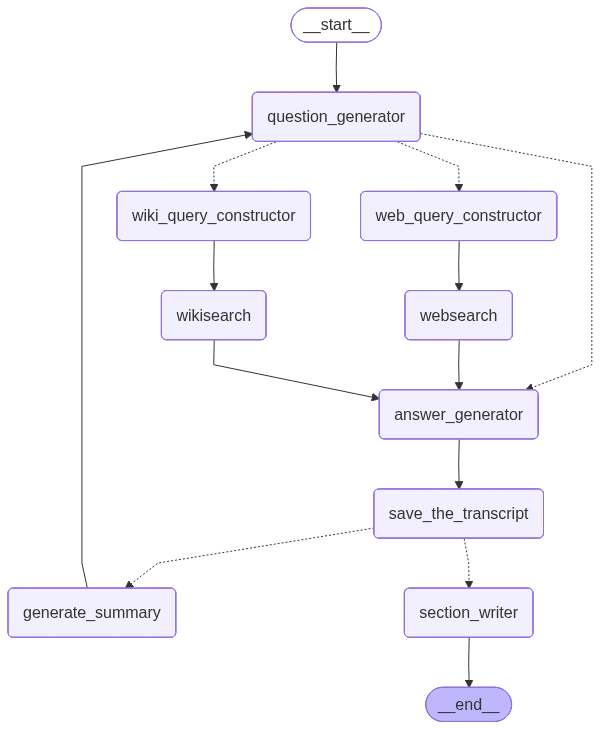

In [9]:
# Add nodes
builder = StateGraph(state_schema=ConsultationState, output_schema=ConsultationOutputState)
builder.add_node(question_generator)
builder.add_node(web_query_constructor)
builder.add_node(wiki_query_constructor)
builder.add_node(websearch)
builder.add_node(wikisearch)
builder.add_node(answer_generator)
builder.add_node(save_the_transcript)
builder.add_node(generate_summary)
builder.add_node(section_writer)

# Add edges (logic)
builder.add_edge(START, "question_generator")
builder.add_conditional_edges("question_generator", skip_the_search, ["answer_generator", "wiki_query_constructor", "web_query_constructor"])
builder.add_edge("wiki_query_constructor", "wikisearch")
builder.add_edge("web_query_constructor", "websearch")
builder.add_edge(["websearch", "wikisearch"], "answer_generator")
builder.add_edge("answer_generator", "save_the_transcript")
builder.add_conditional_edges("save_the_transcript", continue_consultation, ["generate_summary", "section_writer"])
builder.add_edge("generate_summary", "question_generator")

# Compile the subgraph
consultation_subgraph = builder.compile()

# Display the subgraph (optional)
display(Image(consultation_subgraph.get_graph().draw_mermaid_png()))

### Parent graph and parallelisation

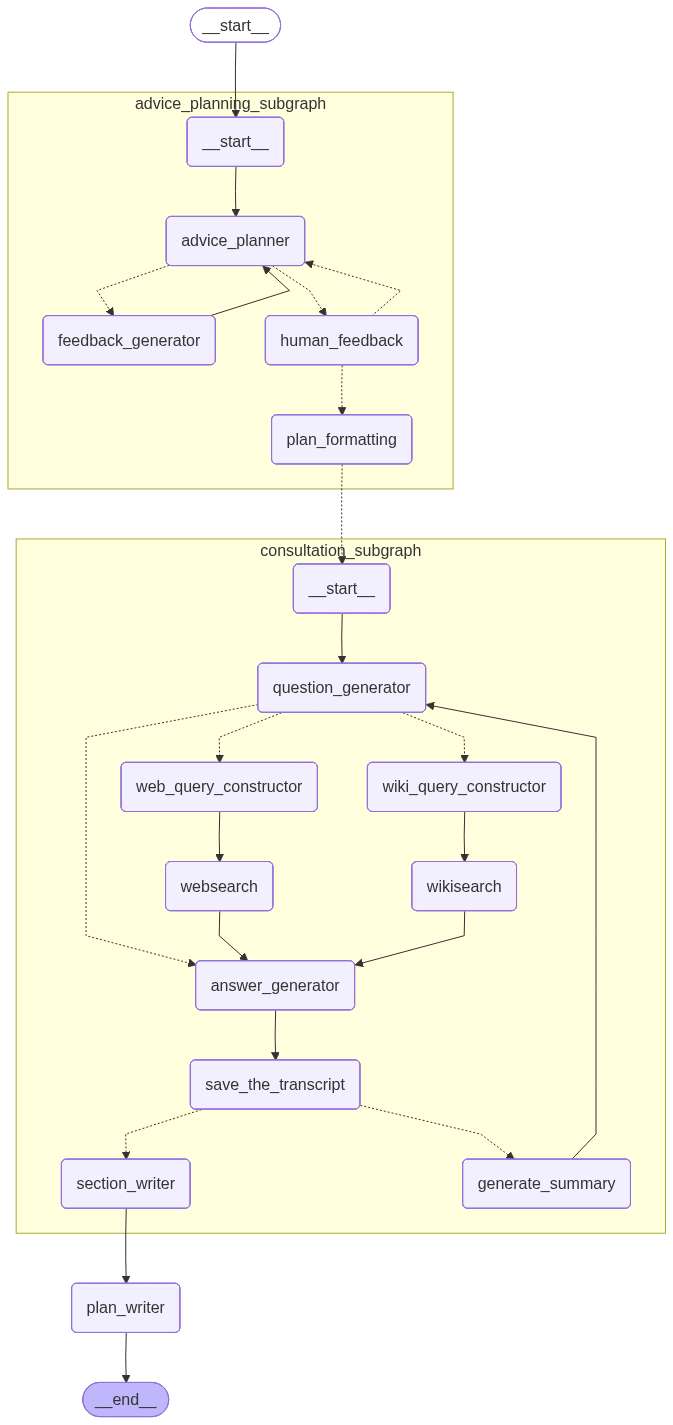

In [10]:
# Parent graph state
class OverallState(TypedDict):
    problem: str # problem reported by a user
    max_steps: int # maximum number of steps in the wellbing action plan
    max_cycles: int # depth of research across both subgraphs (advice planner and consultation) 
    sections: Annotated[list, operator.add] # Send() API key where all written sections are aggregated
    final_plan: str # Final version of the plan including all individual sections

# Dynamic parallelisation logic (mapping step of the Map-Reduce workflow)
def map_to_consultation(state: PlanningOutputState):
    
    """Conditional edge to map each step in the plan to an individual instance of the consultation_subgraph."""
    
    # Print progress message
    log("[Consultation] Searching evidence for the drafted plan...")

    steps = state['steps']
    problem = state["problem"]
    max_cycles = state.get("max_cycles", 2)

    # Map each step
    return [Send("consultation_subgraph", {"step": step,
                                           "problem": problem,
                                           "max_cycles": max_cycles}) for step in steps]


plan_writer_instructions = """# Identity an objectives:
You are an expert technical writer creating a polished version of a Wellbeing Action Plan. 
You are presented with pre-written individual sections of the plan, each focusing on a different actionable step a client can take to deal with the problem they have reported:

## Their problem:

{problem}

## Pre-written sections:

{all_sections}

---

# Follow these steps:    
1. Review the pre-written sections for each step of the plan.
2. Consolidate these sections into one Wellbeing Action Plan. 
3. Aim to keep the individual sections unchanged, unless you think their style/flow could be improved wthout loosing their meaning and detail.
4. Check if the sections don't duplicate one another. If the do, shift focus to another aspect of the pre-written section so it is more distinct form other sections.
4. Include the title headers for each section while excluding the `### Summary` headers.
5. There should be only one Summary section in the finished plan with a brief outline of all the steps.
6. Use markdown formatting. 
7. Start the plan with a single title header: `# Personalised Wellbeing Action Plan`
8. Preserve any citations in the sections, which will be annotated in brackets, for example [1] or [2]
9. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
10. List your sources in order and do not repeat.
11. Include no pre-amble for the plan. Only output the finished plan.
12. If you format some steps as a numbered list, be consistent and do the same for other sections (if appropriate).

12. Expected structure of the plan:

# Personalised Wellbeing Action Plan

## Summary

Body of text for the summary.

## Section header (with actual title)

Body of text for the section.

...

### Sources

[1] Source 1
[2] Source 2 
...

""" 


# Final node
def plan_writer(state: OverallState):
    
    """Node writing the final version of the wellbeing action plan."""
    
    # Print progress message
    log("[Finalising] Writing final version of personalised wellbeing action plan...")

    problem = state["problem"]
    sections = state["sections"]

    # Format the instructions
    formatted_plan_instructions = plan_writer_instructions.format(
        problem=problem,
        all_sections="\n\n---\n\n".join([section for section in sections]) # Format all pre-written sections
    )

    messages = [
        SystemMessage(content=formatted_plan_instructions),
        AIMessage(content="Write a finished version of the Wellbeing Action Plan")
    ]

    # Generate the final plan
    final_plan = llm_5_mini.invoke(messages)

    # Print progress message
    if final_plan.content:
        log("[Completed] Plan successfully generated!")

    return {"final_plan": final_plan.content}


# Build the parent graph
builder = StateGraph(OverallState)
# Add nodes (subgraphs)
builder.add_node("advice_planning_subgraph", advice_planning_subgraph)
builder.add_node("consultation_subgraph", consultation_subgraph)
builder.add_node("plan_writer", plan_writer)

# Add logic
builder.add_edge(START, "advice_planning_subgraph")
builder.add_conditional_edges("advice_planning_subgraph", map_to_consultation, ["consultation_subgraph"])
builder.add_edge("consultation_subgraph", "plan_writer")
builder.add_edge("plan_writer", END)

# Include memory
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Display complete graph (optional)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Running the graph

In [11]:
def run_with_multiple_interrupts(graph, initial_input, config):
    """Custom function to run the graph with support for multiple interruptions"""
    
    # Initialise start of timing for the performance logs
    init_timer()

    # Initial run
    result = graph.invoke(initial_input, config=config)
    
    # Keep processing interruptions until "No feedback" is input by the user
    while result.get("__interrupt__", ""):
        # Get the interrupt message
        interrupt_message = result["__interrupt__"][0].value
        print(interrupt_message)
        
        # Get user input
        user_input = input("Provide your response:\n> ")
      
        # Resume and get new result
        result = graph.invoke(Command(resume=user_input), config=config)
         
    return result

# Test run
thread = {'configurable': {"thread_id": "1"}}
problem = "I'm feeling very stressed at work, because I don't like being surrounded by many people in an open office."

final_result = run_with_multiple_interrupts(
    graph=graph,
    initial_input={"problem": problem, "max_steps": 3},
    config=thread
)

[22:49:53 | +000.05s] [Planner] Drafting the plan...
[22:49:57 | +004.27s] [Planner] Draft successfully generated!


* * * * *

Do you have any suggestions for the proposed steps in your Wellbeing Action Plan? Type 'No feedback' if none.

Proposed steps:

- Step -
Theme: Workplace adjustments  
Helpful tip: Request a more private workspace or explore the possibility of working remotely for part of the week to reduce stress caused by the open office environment.

- Step -
Theme: Therapy  
Helpful tip: Consider seeking support from a therapist to develop coping strategies for managing stress and navigating social discomfort in the workplace.

- Step -
Theme: Lifestyle changes  
Helpful tip: Practice mindfulness or meditation techniques daily to help manage stress and improve your overall sense of calm and focus.

* * * * *


[22:50:15 | +022.88s] [User input] Feedback from the user: "I can't work remotely. What type of therapy do you suggest?"
[22:50:15 | +022.88s] [Planner] Drafting the

In [12]:
# Display the Wellbeing Action Plan
Markdown(final_result["final_plan"])

# Personalised Wellbeing Action Plan

## Summary

This plan outlines three complementary steps to reduce stress caused by working in a busy open office:
1. Create a quieter, more focused workspace by discussing options with your manager and using practical adjustments (e.g., noise-cancelling headphones, visual barriers) if relocation isn’t possible [1][2].
2. Explore Solution-Focused Brief Therapy (SFBT) to develop short-term, goal-oriented strategies (using techniques like the miracle question and scaling) to manage workplace stress [3][4].
3. Use journaling as a regular, flexible tool to process thoughts and emotions, track patterns, and develop clarity about stress triggers and coping strategies [5][6].

## Creating a Quieter and More Focused Workspace

Working in an open office can be challenging, especially when noise and distractions impact your ability to focus and perform at your best. To address this, consider requesting a more private workspace or implementing strategies to create a quieter and more focused environment. When discussing this with your manager, it’s important to frame your request in terms of productivity and work performance. For example, you could say, “I’ve noticed that I work more effectively in quieter environments. I think I could be a lot more productive if my desk were in a quieter spot. Would it be possible to explore options for a workspace that better supports my focus?” This approach emphasizes how the adjustment will benefit your work, making the request feel professional and reasonable [1].

If your manager inquires further about why the current setup is challenging, focus on how the environment impacts your productivity rather than framing it as a personal issue. You might explain, “The open office environment can be quite noisy and distracting at times, which makes it harder for me to focus on tasks that require deep concentration. I want to make sure I’m performing at my best, and I think a quieter workspace would help me stay more productive and efficient.” This explanation highlights your proactive approach to improving your performance and finding solutions [2].

If moving to a quieter workspace isn’t feasible, there are additional strategies you can try. Noise-canceling headphones or white noise can help reduce distractions and create a more focused environment. You might also consider creating a visual barrier at your desk using items like desk dividers, plants, or books to enhance your sense of privacy. These adjustments can make a significant difference in managing the challenges of an open office while you work toward a longer-term solution [2].

By taking these steps, you can create a workspace that better supports your productivity and wellbeing, even in a busy office environment.

## Exploring Solution-Focused Brief Therapy (SFBT) for Workplace Stress

If traditional therapeutic approaches like Cognitive Behavioral Therapy (CBT) do not resonate with you, exploring alternative methods such as Solution-Focused Brief Therapy (SFBT) can be a highly effective way to address workplace stress. SFBT is a goal-oriented therapy that emphasizes solutions rather than problems, making it particularly suitable for managing stress in specific environments, such as an open office setting [3][4].

SFBT works by helping you envision a future where your stress is reduced and identifying small, actionable steps to move toward that goal. Two key techniques in SFBT that can be applied to your situation are the "miracle question" and "scaling questions." 

1. The Miracle Question: This exercise encourages you to imagine what your ideal workday would look like if your stress were completely gone. For example, you might visualize walking into the office feeling calm, having a quiet space to work, and being able to focus without distractions. This process helps clarify what changes you want to see and provides a foundation for identifying practical steps to achieve them [4].

2. Scaling Questions: These help you assess your current stress levels and track progress over time. For instance, you might rate your stress on a scale from 0 to 10, where 0 is completely unmanageable and 10 is stress-free. By identifying what makes your stress a 3 instead of a 0, you can uncover strategies that are already helping, such as using noise-canceling headphones or taking breaks in quieter areas. From there, you can brainstorm small changes to move closer to a more comfortable level, like discussing quiet work hours with your manager or creating a designated focus area [3][4].

By focusing on what is within your control and building on what already works, SFBT provides a structured yet flexible approach to reducing workplace stress. It is also a brief therapy, meaning you can see meaningful results in just a few sessions. This makes it a practical and time-efficient option for addressing stress in an open office environment.

## Discover the Power of Journaling for Stress Relief

When managing stress, especially in environments that feel overwhelming, such as a busy open office, engaging in a relaxing hobby can provide a much-needed sense of calm and control. Journaling is an excellent choice for stress relief, as it allows you to process your thoughts and emotions in a private, reflective way. It’s a simple yet effective tool to help you unwind and regain focus.

To get started with journaling, begin by keeping it simple. Write about whatever is on your mind—your thoughts, feelings, or even a recap of your day. You can also focus on specific stressors, such as your experiences in the open office, and explore how they make you feel. This practice can help you gain clarity and release pent-up emotions [5][6].

Consistency is key to making journaling a habit. Choose a time of day that works best for you, such as mornings to set intentions or evenings to reflect on your day. Start with a few times a week to avoid feeling overwhelmed, and gradually increase the frequency as it becomes a natural part of your routine [5].

Don’t worry about structure or grammar—let your thoughts flow freely. If you’re unsure what to write, use prompts like:
- What made me feel stressed today?
- What am I grateful for right now?
- How did I feel in the open office today, and why?
These prompts can guide your writing and help you focus on the present moment [5][6].

To make journaling even more accessible, carry a small notebook or use a journaling app to jot down thoughts throughout the day. This way, you can capture moments or feelings you want to explore later. If writing feels restrictive, consider adding drawings, doodles, or even collages to your journal for a more creative approach [5].

Finally, while your journal is a private space, reflecting on past entries can help you notice patterns and track your progress over time. Journaling is a flexible and personal activity, so adapt it to suit your needs and preferences as you go [6].

## Sources

[1] https://workplace.stackexchange.com/questions/124622/i-wish-to-move-desks-at-my-company-how-to-word-this-request  
[2] https://www.asianefficiency.com/productivity/6-ways-reduce-unwanted-noise-workspace/  
[3] https://olympicbehavioralhealth.com/therapies/sfbt/  
[4] https://researchgate.net/publication/360032622_Solution-Focused_Therapy_for_Workplace_Stress_and_Burnout  
[5] https://jedfoundation.org/resource/how-to-start-journaling/  
[6] https://psychcentral.com/stress/how-to-begin-journaling-for-stress-relief